In [1]:
import sys
import os
sys.path.append("../")
sys.path.append("../analysis")

In [2]:
import re
from itertools import product

In [3]:
import uproot
import awkward as ak
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import vector
import hist
vector.register_awkward()
from hist import Hist

In [5]:
import analysis.datasets.local as datasets
import analysis.selection.cuts as cuts

In [6]:
from analysis.selection.extend import extend_dimuon_q2, extend_dtf
from analysis.selection.mctruth import *

In [7]:
from analysis.plotting.plotting import set_lhcb_style
set_lhcb_style()

In [9]:
from analysis.variables import Var, mass_observables, get_var_input_branches, mva_inputs, multiplicity

In [10]:
import ROOT
ROOT.ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.30/02


In [11]:
decay = 'B2omegaMuMu'
eventtypes = 90000000
magpol = ['magdown', 'magup']
datatypes = [2016, 2017, 2018]

In [12]:
def find_files(eventype, magpol, datatype):
    datadir = datasets.get_local_data_path(decay, eventype)
    fs = [os.path.join(datadir, f'{pol}_{year}.root') for year, pol in product(datatypes, magpol)]
    return fs

In [13]:
files = find_files(eventtypes, magpol, datatypes)

In [14]:
jpsicut = '&'.join([c.format('Jpsi') for c in cuts.jpsiwindow])
jpsicut = f'({jpsicut})'
jpsicut

'(Jpsi_M>3047&Jpsi_M<3147)'

In [15]:
psicut = '&'.join([c.format('Jpsi') for c in cuts.psi2swindow])
psicut = f'({psicut})'
psicut

'(Jpsi_M>3636&Jpsi_M<3736)'

In [16]:
sbcut = 'B_M>5500&B_M<6000'

In [17]:
def prepare_df(files):
    df = ROOT.RDataFrame('DecayTree', files)
    df = extend_dimuon_q2(df)
    df = extend_dtf(df)
    return df

In [26]:
df = prepare_df(files)

In [27]:
branches = get_var_input_branches(mass_observables + mva_inputs + multiplicity)

In [28]:
cols = df.GetColumnNames()
cols =  [str(c) for c in cols]
#pattern = re.compile(r'^(B_(?!(JpsiConsDTF|Hlt|pi0ConsDTF))|Jpsi_(?!Hlt)|omega_|pi0_)')
pattern = re.compile(r'^(Jpsi_P|pi.*_P(?!ID)|mu.*_P(?!ID))')
cols = [c for c in cols if pattern.match(c)]
cols += branches
cols += ['dimuon_q2']
len(cols)

104

In [30]:
arr = ak.to_dataframe(ak.from_rdataframe(df, cols))

In [31]:
from analysis.utils.histograms import *

In [32]:
from analysis.locations import Locations
def save_fig(fig_id, tight_layout=True, fig_extension="jpg", resolution=300):
    path = os.path.join(Locations.get_plots_dir(), fig_id + "." + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [33]:
etacut = '&'.join([c.format('omega') for c in cuts.etawindow])
omegacut = '&'.join([c.format('omega') for c in cuts.omegawindow])
phicut = '&'.join([c.format('omega') for c in cuts.phiwindow])
mesoncut = f'({etacut})|({omegacut})|({phicut})'
mesoncut

'(omega_M>498&omega_M<598)|(omega_M>730&omega_M<830)|(omega_M>970&omega_M<1070)'

In [34]:
jpsidf = arr.query(jpsicut)

In [35]:
h_jpsi = { var.name: hist_from_var(var, jpsidf) for var in mass_observables }
h_jpsi_x = { var.name: hist_from_var(var, jpsidf.query(mesoncut)) for var in mass_observables }
h_jpsi_eta = { var.name: hist_from_var(var, jpsidf.query(etacut)) for var in mass_observables }
h_jpsi_omega = { var.name: hist_from_var(var, jpsidf.query(omegacut)) for var in mass_observables }
h_jpsi_phi = { var.name: hist_from_var(var, jpsidf.query(phicut)) for var in mass_observables }
print(h_jpsi_x.keys())

dict_keys(['Dimuon_M', 'Jpsi_M', 'pi0_M', 'pipipiz_M', 'eta_M', 'omega_M', 'phi_M', 'B_M', 'B_pizDTF_M', 'B_JPsiDTF_M'])


Saving figure X_M_jpsi


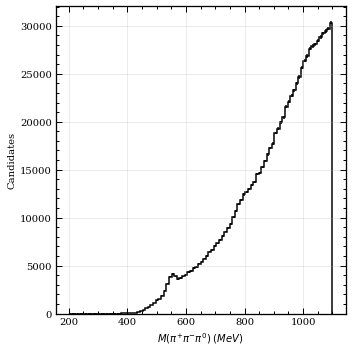

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_hist(ax, h_jpsi['pipipiz_M'])
save_fig('X_M_jpsi');

Saving figure B_DTF_M_jpsix


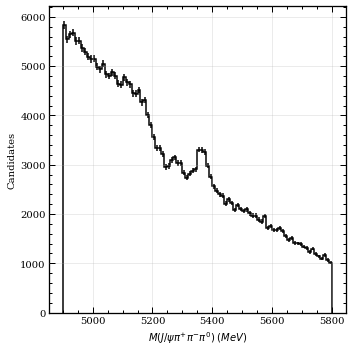

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_hist(ax, h_jpsi_x['B_JPsiDTF_M'])
save_fig('B_DTF_M_jpsix');

Saving figure B_DTF_M_jpsieta


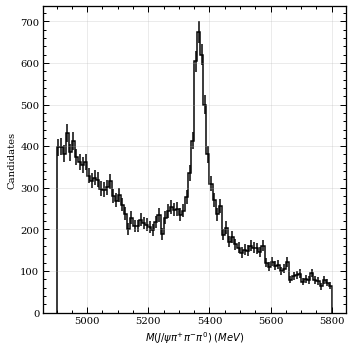

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_hist(ax, h_jpsi_eta['B_JPsiDTF_M'])
save_fig('B_DTF_M_jpsieta');

Saving figure B_DTF_M_jpsiomega


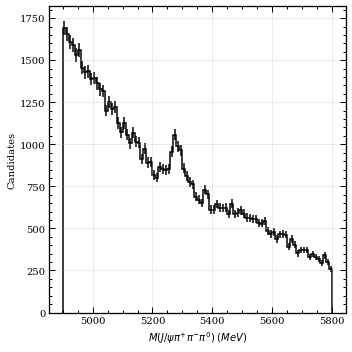

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_hist(ax, h_jpsi_omega['B_JPsiDTF_M'])
save_fig('B_DTF_M_jpsiomega');

Saving figure B_DTF_M_jpsiphi


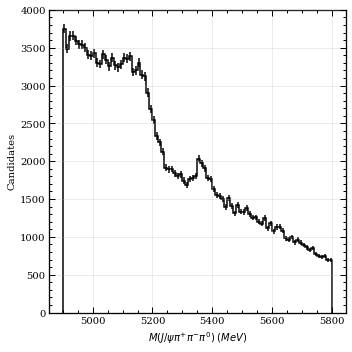

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_hist(ax, h_jpsi_phi['B_JPsiDTF_M'])
save_fig('B_DTF_M_jpsiphi');

In [44]:
observables = [
    Var('Dimuon_M', 'Jpsi_M', '$m(\mu^{+}\mu^{-})\; (MeV)$', (0, 6000), 200, None),
    Var('Jpsi_M', 'Jpsi_M', '$m(\mu^{+}\mu^{-})\; (MeV)$', (2947, 3247), 50, None),
    Var('pipipiz_M', 'omega_M', '$m(\pi^{+}\pi^{-}\pi^{0})\; (MeV)$', (200, 1100), 100, None),
    Var('eta_M', 'omega_M', '$m(\pi^{+}\pi^{-}\pi^{0})\; (MeV)$', (500, 600), 50, None),
    Var('omega_M', 'omega_M', '$m(\pi^{+}\pi^{-}\pi^{0})\; (MeV)$', (730, 830), 50, None),
    Var('phi_M', 'omega_M', '$m(\pi^{+}\pi^{-}\pi^{0})\; (MeV)$', (970, 1070), 50, None),
    Var('B_M', 'B_M', '$m(\mu^{+}\mu^{-}\pi^{+}\pi^{-}\pi^0)\; (MeV)$', (5100, 6000), 90, None),
    Var('B_pizDTF_M', 'B_pizDTF_M', '$m(\mu^{+}\mu^{-}\pi^{+}\pi^{-}\pi^{0})\; (MeV)$', (5100, 6000), 90, None),
    Var('B_JPsiDTF_M', 'B_JpsiDTF_M', '$m(J/\psi\pi^{+}\pi^{-}\pi^{0})\; (MeV)$', (5100, 6000), 90, None),
]
observables = {v.name: v for v in observables}

In [ ]:
def hist_from_array(arr, name, label, range, bins, transform=None):
    if transform is not None:
        arr = transform(arr)
    h = Hist.new.Reg(bins, *range).Double()
    h.overflow = False
    h.underflow = False
    h.fill(arr)
    h.label = label
    h.name = name
    return h

In [ ]:
def hist_from_var(var, arr):
    return hist_from_array(arr[var.branch], var.name, var.label, var.range, var.bins, var.transform)

In [ ]:
def plot_hist(ax, h, logy=False, **kwargs):
    #mplhep.histplot(h, ax=ax, histtype='step', color='black', flow="none", label=label)
    histtype = kwargs.get('histtype', 'step')
    color = kwargs.get('color', 'black')
    label = kwargs.get('label', None)
    flow = kwargs.get('flow', 'none')
    density = kwargs.get('density', False)
    mplhep.histplot(h, ax=ax, histtype=histtype, color=color, flow=flow, label=label, density=density)
    ax.set_xlabel(h.label)
    ax.set_ylabel('Candidates')
    #ax.set_title(h.name)
    if logy:
        ax.set_yscale('log')

In [41]:
jpsiq2 = '&'.join([c.format('dimuon_q2') for c in cuts.jpsiq2])
jpsiq2 = f'({jpsiq2})'
psiq2 = '&'.join([c.format('dimuon_q2') for c in cuts.psiq2])
psiq2 = f'({psiq2})'
print(jpsiq2)
print(psiq2)

(dimuon_q2>8.0&dimuon_q2<11.0)
(dimuon_q2>12.5&dimuon_q2<15.0)


In [42]:
etacut = '&'.join([c.format('omega') for c in cuts.etawindow])
omegacut = '&'.join([c.format('omega') for c in cuts.omegawindow])
phicut = '&'.join([c.format('omega') for c in cuts.phiwindow])
mesoncut = f'({etacut})|({omegacut})|({phicut})'
mesoncut

'(omega_M>498&omega_M<598)|(omega_M>730&omega_M<830)|(omega_M>970&omega_M<1070)'

In [43]:
jpsidf = arr.query(jpsicut)
nrdf = arr.query(f'~{jpsiq2}&~{psiq2}')

In [ ]:
observables.keys()

In [45]:
h_X = hist_from_var(observables['pipipiz_M'], jpsidf)
h_eta = hist_from_var(observables['eta_M'], jpsidf)
h_omega = hist_from_var(observables['omega_M'], jpsidf)
h_phi = hist_from_var(observables['phi_M'], jpsidf)

Saving figure pipipizmass


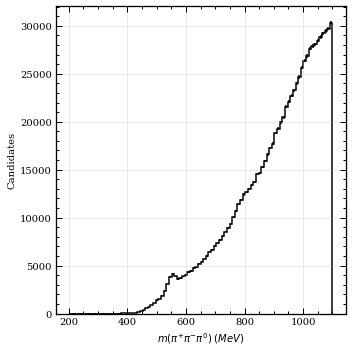

In [46]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_hist(ax, h_X)
#plot_hist(ax[0, 1], h_eta)
#plot_hist(ax[1, 0], h_omega)
#plot_hist(ax[1, 1], h_phi)
save_fig('pipipizmass');

In [ ]:
def fourvector(px, py, pz, pe): 
    return vector.array({'px': px, 'py': py, 'pz': pz, 'E': pe})

In [47]:
h_nr_B = hist_from_var(observables['B_M'], nrdf)
h_nr_B_sb = hist_from_var(observables['B_M'], nrdf.query(sbcut))

Saving figure BMSB


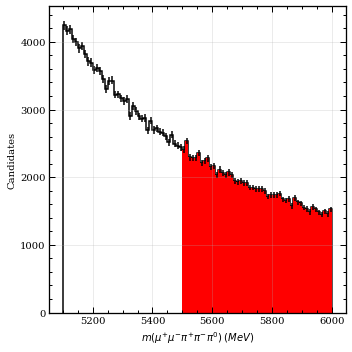

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_hist(ax, h_nr_B)
plot_hist(ax, h_nr_B_sb, histtype='fill', color='red')
save_fig('BMSB')

Saving figure BMSB


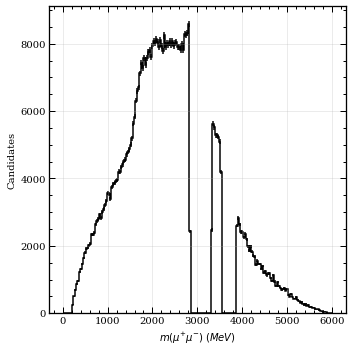

In [49]:
h_nr_mumu = hist_from_var(observables['Dimuon_M'], nrdf)
fig, ax = plt.subplots(figsize=(5, 5))
plot_hist(ax, h_nr_mumu)
save_fig('BMSB')

In [50]:
nrdf.to_pickle('../output/pickles/B2X0MuMu_data.pkl')